# Purpose:
Generate a burn severity map based on the input fire perimeter and UAVSAR HV backscatter data

In [1]:
import sys
# path to the python folder with utils
sys.path.append('/mnt/karenan/UAVSAR-Fire-Research/uavsar_wildfire_classification/python')

import rasterio
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from rio_utils import (reproject_arr_to_match_profile)
from process_utils import (preprocess_data, 
                           get_model_labels)

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the images cropped by the fire perimeter
    - Could be cropped by the published perimeter if available
    - Else, the generated perimeter could be used

In [2]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [3]:
# path to the folder with the images cropped by the fire perimeter
data_dir = Path('/mnt/karenan/fasmee/fishlake/classify_fishla_01601_19601_230727_231017')
#data_dir = Path('../data_old/la_tuna/cropped_by_perimeter')

tifs = sorted(list(data_dir.glob('./*perimeter*.tif')))
tifs

[PosixPath('/mnt/karenan/fasmee/fishlake/classify_fishla_01601_19601_230727_231017/fishlake_weighted_inc_merge_hv_0_perimeter_intersection_uavsar.tif'),
 PosixPath('/mnt/karenan/fasmee/fishlake/classify_fishla_01601_19601_230727_231017/fishlake_weighted_inc_merge_hv_1_perimeter_intersection_uavsar.tif')]

---
Open the post-RTC images

Let `hv_0` and `profile_0` correspond to the pre-fire image, and `hv_1` and `profile_1` correspond to the post-fire image. 

In [4]:
# open the tifs
bands, profiles = zip(*map(open_one, tifs))
hv_0 = bands[0]
hv_1 = bands[1]
profile_0 = profiles[0]
profile_1 = profiles[1]

In [5]:
##
#hv_0[hv_0 == -1] = np.nan
#hv_1[hv_1 == -1] = np.nan

In [5]:
# compute log ratio for change detection
log_ratio = np.log10(hv_0/hv_1)

---
This is the preprocessed raster image we will work with to classify burn severity within the perimeter

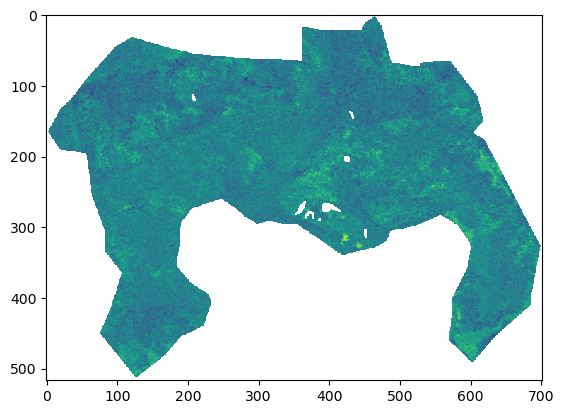

In [6]:
plt.imshow(log_ratio)

## Classification
Selecting the K-Means model with n_clusters=4

4 labels corresponds to: **{1: 'Unburned', 2: 'Low', 3: 'Moderate', 4: 'High'}**

In [21]:
model = KMeans(n_clusters=10, ##3
               n_init=10,
               random_state=1)

In [22]:
classes = get_model_labels(log_ratio, model)
classes = classes + 1

In [23]:
classes

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

---
This is what the output burn severity mapping will look like

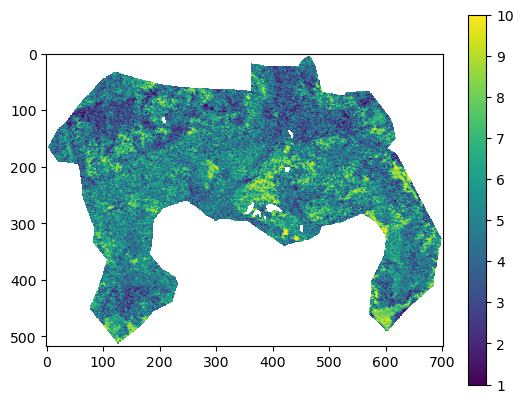

In [24]:
plt.imshow(classes)
plt.colorbar()

**Parameter**
- `output_name`(str): Name of the output burn seveity map [**.tif**]

In [25]:
output_name = "fishla_sbs_10.tif"

In [26]:
with rasterio.open(output_name, "w", **profile_0) as dest:
    dest.write(classes, 1)

---
### Output Severity Distribution Visualization
Visualizes the distribution of the log ratio values for each burn severity class through boxplot

/tmp/ipykernel_139007/3579219805.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classes', y='Log_Ratio', data=data, palette=color_palette)


ValueError: The palette dictionary is missing keys: {'5.0', '4.0', '9.0', '7.0', '3.0', '6.0', '1.0', '8.0', '10.0', '2.0'}

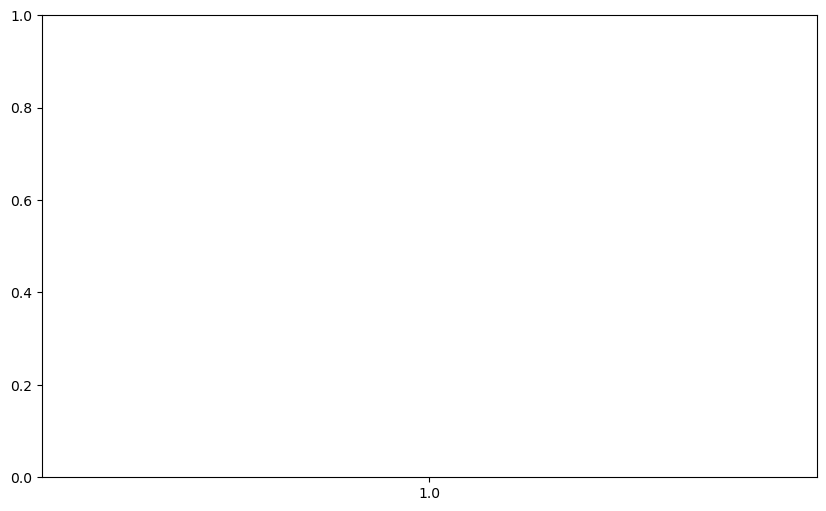

In [27]:
# Flatten and filter out np.nan values
flat_log_ratio = log_ratio[~np.isnan(classes)]
flat_classes = classes[~np.isnan(classes)]

# Create a DataFrame for seaborn
data = pd.DataFrame({'Classes': flat_classes, 'Log_Ratio': flat_log_ratio})

# Color Palette corresponding to MTBS's mapping
color_palette = {1: '#006400', 2: '#7fffd4', 3: '#ffff00', 4: '#ff0000'}

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Classes', y='Log_Ratio', data=data, palette=color_palette)

# Add median values
medians = data.groupby('Classes')['Log_Ratio'].median()
for idx, val in medians.items():
    plt.text(idx - 1, val, f'{val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontweight='extra bold')

# Create a legend
legend_labels = {1: 'Unburned', 2: 'Low', 3: 'Moderate', 4: 'High'}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], markersize=10, markerfacecolor=color_palette[key]) for key in color_palette]
plt.legend(handles=legend_elements)

# Plot Labelings
plt.title('Generated Bobcat Log Ratio by Severity')
plt.xlabel('Burn Severity Class')
plt.ylabel('HV Log Ratio')
caption = 'Median Log Ratio value for each class is shown in white'
plt.figtext(0.5, 0, caption, ha='center', fontsize=10, color='black')
plt.show()